<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

# assert torch.backends.mps.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [2]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):

    # The transform argument allows you to pass in any function that can modfiy the data
    # like rotating the image 90 degrees and then transform it to a Tensor
    self.data = datasets.FashionMNIST(root, train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)

  # This overrides the builtin Python __getitem__() function
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  """
  This also overrides the builtin Python __len__() function
  You don't have to return the exact amount, like if you only want to train on
  a certain amount of pictures
  """
  def __len__(self):
    return len(self.data)


___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

* CrossEntropyLoss
* Conv2D

**DONE:**

___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [4]:
def create(n):
     x = np.random.normal(size=n)
     x -= x.mean()
     x /= np.linalg.norm(x)

create(10).mean()

-0.5540492809458585


1.3877787807814457e-17

In [39]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0):
    self.__dict__.update(locals()) # Initializes all parameters as members of the class
    super(CrossEntropyLoss,self).__init__()

  def forward(self, y_hat, y_truth):
    # Use torch.gather for efficient indexing
    y_hat_class = torch.gather(y_hat, 1, y_truth.view(-1, 1))

    # Use torch.logsumexp on the entire tensor for efficiency
    loss = -y_hat_class + torch.logsumexp(y_hat, dim=1, keepdim=True)

    # Take the mean across the batch
    return torch.mean(loss)
    batch_size = len(y_hat)

    all_loss = [] # [- y_hat[i, y_truth[i]] + torch.logsumexp(y_hat[i,],0) for i in range(batch_size)]
    for i in range(batch_size):
      class_index = y_truth[i]
      loss = - y_hat[i,class_index] + torch.logsumexp(y_hat[i,],0)
      all_loss.append(loss)
    return torch.mean(torch.stack(all_loss))





class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size,
               stride=1, padding=0, dilation=1, groups=1, bias=True,
               padding_mode='zeros', device=None, dtype=None):
    self.__dict__.update(locals()) # Initializes all parameters as members of the class
    super(Conv2d, self).__init__()

    # (out, in, k, k)
    # out: number of output channels
    # in: number of input channels
    # k: size of kernel
    # Uniform Initialization
    # self.weight = Parameter(torch.Tensor(self.out_channels,
    #                                     self.in_channels,
    #                                     *self.kernel_size))
    # self.weight.data.uniform_(-1,1)

    # Orthogonal Initialization
    # X = np.random.rand(self.out_channels,self.in_channels,*self.kernel_size)
    # U, _, Vt = np.linalg.svd(X, full_matrices=False)
    # self.weight = Parameter(torch.Tensor(Vt.reshape((self.out_channels, self.in_channels, *self.kernel_size))))

    # Xavier Initializiation
    x = np.random.normal(size=(self.out_channels,
                                        self.in_channels,
                                        *self.kernel_size))
    x -= x.mean()
    x /= np.linalg.norm(x)
    self.weight = Parameter(torch.Tensor(x))

    # Uniform Initialization
    self.bias = Parameter(torch.ones(self.out_channels))

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

  def extra_repr(self):
    return f'In Channels: {self.in_channels}, Out Channels: {self.out_channels}, Kernel Size: {self.kernel_size}'


In [40]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x,y = dataset[0]
    c,h,w = x.size()
    output = 10 # Forcing output to be an integer because of fixed classification classes
    self.net = nn.Sequential(
      # c is the input channels (RGB),
      # 10 is the number of kernels produced for the current layer
      # (3,3) is the size of the convolution kernel
      # (1,1) is the amount of space added to the image before convolving
      Conv2d(c, 64, (3,3), padding=(1,1)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(64, 128, (5,5), padding=(2,2)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(128, 128, (5,5), padding=(2,2)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(128, 128, (5,5), padding=(2,2)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(128, 256, (3,3), padding=(1,1)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(256, 512, (3,3), padding=(1,1)), # The num_kernels must match the input layer for vv
      nn.ReLU(),
      Conv2d(512, output, (28,28), padding=(0,0)), # The num_kernels must match the input layer for vv
    )

    total_parameters = (h*w*c + h*w*64 + 3*h*w*128 + h*w*256 + h*w*512 + h*w*10)
    print(f'Total Parameters: {total_parameters}, Initial dims: {h}x{w}x{c}')

  def forward(self, x):
      # (n, 10, 1, 1) original output of self.net(x)
      # (n, 10, 1) 1st squeeze(2)
      # (n, 10) 2nd squeeze(2)
      return self.net(x).squeeze(2).squeeze(2)


In [ ]:
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('.', train=True)
validation_dataset = FashionMNISTProcessedDataset('.', train=False)

# Instantiate your data loaders
train_loader = DataLoader(train_dataset, batch_size=42)
val_loader = DataLoader(validation_dataset, batch_size=42)

# Instantiate your model and loss and optimizer functions
device = torch.device('mps')
model = ConvNetwork(train_dataset)
model = model.to(device)
objective = CrossEntropyLoss()
objective_true = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model

In [ ]:
# Run your training / validation loops
losses = []
validations = []
val_accuracy = []
train_accuracy = []

update_counter = 1
num_epochs = 2
loop = tqdm(total=len(train_loader)*num_epochs, position=0)
for epoch in range(num_epochs):
  # train
  for batch, (x, y_truth) in enumerate(train_loader):
    loop.update(update_counter)
    # learn
    x, y_truth = x.to(device), y_truth.to(device)

    # Helps save on space
    # Instead of filling an array of size 32 ints,
    # fill with None, which has size 16
    optimizer.zero_grad(set_to_none=True)

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    losses.append(loss.item())

    accuracy = (torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()
    train_accuracy.append(accuracy.item())

    # Uses tqdm module to add labels to the progress bar for training
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      validation_counts = []
      accuracy_counts = []
      for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x.to(device))

        accuracy = (torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()
        accuracy_counts.append(accuracy.item())

        validation_counts.append(objective(y_hat, y_truth.to(device)).item())

      val = np.mean(validation_counts)
      accuracy = np.mean(accuracy_counts)
      val_accuracy.append((len(losses), accuracy))


      validations.append((len(losses), val))
      loop.set_description(f'epoch: {epoch+1} batch: {batch} accuracy: {accuracy*100:.2f}% loss: {val:.4f}')


# Finishes progress bar
loop.close()


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation
set over time. You should experiment with some deep networks and see if you can get a network
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model

**DONE:**


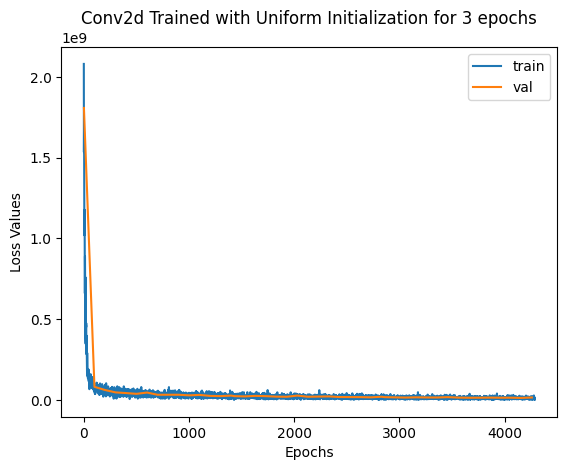

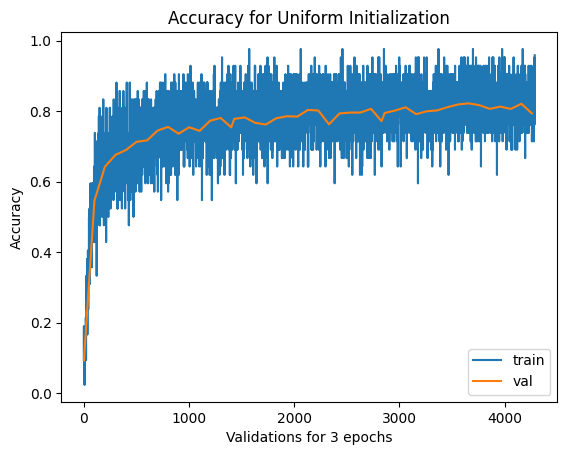

In [14]:
# Go back up and try a few different networks and initialization strategies
# Plot training and validation loss for uniform initialization
# Plot training and validation accuracy for uniform initialization
a,b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a,b, label='val')
plt.title(f'Conv2d Trained with Uniform Initialization for {num_epochs} epochs')
plt.ylabel('Loss Values')
plt.xlabel('Epochs')
plt.legend()
plt.show()


a,b = zip(*val_accuracy)
plt.plot(train_accuracy, label='train')
plt.plot(a,b, label='val')
plt.title('Accuracy for Uniform Initialization')
plt.xlabel(f'Validations for {num_epochs} epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

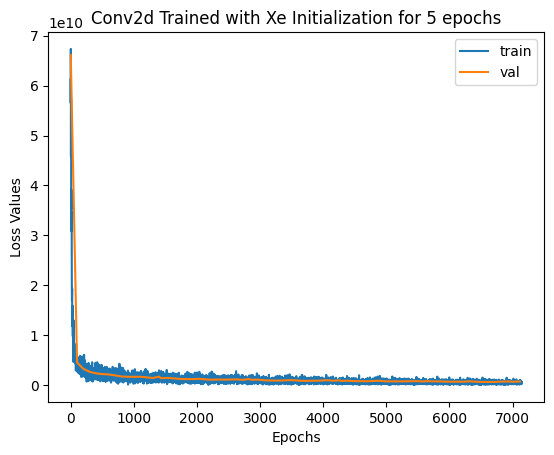

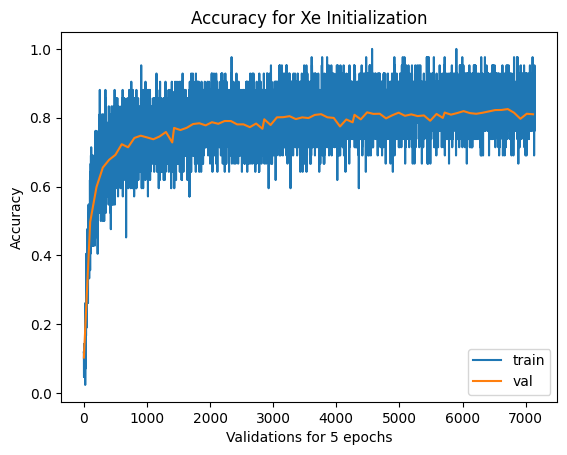

In [38]:
# Plot training and validation loss for Xe initialization
# Plot training and validation accuracy for Xe initialization
a,b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a,b, label='val')
plt.title(f'Conv2d Trained with Xe Initialization for {num_epochs} epochs')
plt.ylabel('Loss Values')
plt.xlabel('Epochs')
plt.legend()
plt.show()


a,b = zip(*val_accuracy)
plt.plot(train_accuracy, label='train')
plt.plot(a,b, label='val')
plt.title('Accuracy for Xe Initialization')
plt.xlabel(f'Validations for {num_epochs} epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

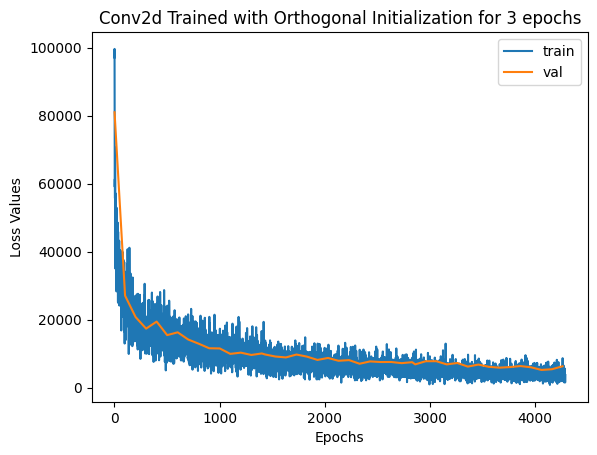

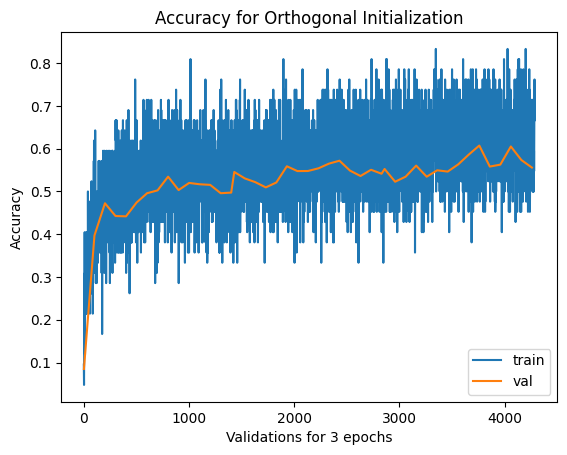

In [26]:
# Plot training and validation loss for orthogonal initialization
# Plot training and validation accuracy for orthogonal initialization
a,b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a,b, label='val')
plt.title(f'Conv2d Trained with Orthogonal Initialization for {num_epochs} epochs')
plt.ylabel('Loss Values')
plt.xlabel('Epochs')
plt.legend()
plt.show()


a,b = zip(*val_accuracy)
plt.plot(train_accuracy, label='train')
plt.plot(a,b, label='val')
plt.title('Accuracy for Orthogonal Initialization')
plt.xlabel(f'Validations for {num_epochs} epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Compute and print the number of parameters in the model


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3,3), padding=(1,1))
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3,3), padding=(2,2))
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3,3), padding=(6,6))

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2,2))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3,3))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(14,14))

*Using Kernel size of 5×3:*
Assuming kernel size is h=5 and w=3
* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(4,2), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1,1), padding=(0, 0))
**TODO:**

* Answer all the questions above

**DONE:**


In [13]:
# Write some test code for checking the answers for these problems (example shown in the video)
